In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc
import sys
import os
import f90nml
import seaborn as sns

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

In [157]:
# Read in CNT US data and remove # lines using sed, run timecorr_z.pl to get corrtime data
# For timecorr_z.pl, see Position-dependent diffusion coefficient of ions section at DOI: 10.1021/jp906791b

dataDir='/data/yichun/nanotube_test/US/'
filename='/step8_production.colvars.traj'
for win in np.arange(0,28,1):
    Files='/'.join([dataDir+'window'+'%02g'%win+filename])
    print(Files)
    Out='step8_window'+'%02g'%win+'.dat'
    print(Out)
    !sed '/#/d' $Files > /data/lyna/CNT/US-step9/$Out
    !./timecorr_z.pl /data/lyna/CNT/US-step9/$Out


/data/yichun/nanotube_test/US/window00/step8_production.colvars.traj
step8_window00.dat
zautocorr 0.241573707260238
/data/yichun/nanotube_test/US/window01/step8_production.colvars.traj
step8_window01.dat
zautocorr 0.236186081964792
/data/yichun/nanotube_test/US/window02/step8_production.colvars.traj
step8_window02.dat
zautocorr 0.241579893724605
/data/yichun/nanotube_test/US/window03/step8_production.colvars.traj
step8_window03.dat
zautocorr 0.236562398676786
/data/yichun/nanotube_test/US/window04/step8_production.colvars.traj
step8_window04.dat
zautocorr 0.241489245818511
/data/yichun/nanotube_test/US/window05/step8_production.colvars.traj
step8_window05.dat
zautocorr 0.238926037329617
/data/yichun/nanotube_test/US/window06/step8_production.colvars.traj
step8_window06.dat
zautocorr 0.227822135246959
/data/yichun/nanotube_test/US/window07/step8_production.colvars.traj
step8_window07.dat
zautocorr 0.236962317121552
/data/yichun/nanotube_test/US/window08/step8_production.colvars.traj
ste

In [158]:
# First check the z coordinate data of all windows by plotting histograms
Zdata=[]
tempTable=[]
for win in np.arange(0,28,1):
    Files='/'.join(['/data/lyna/CNT/US-step9/'+'step8_window'+'%02g'%win+'.dat'])
    print(Files)
    tempTable=pd.read_csv(Files,delim_whitespace=True,names=["fs", "z","xy"])
    tempTable['win']=win
    Zdata.append(copy.deepcopy(tempTable))
    
Zdata=pd.concat(Zdata)
Zdata

/data/lyna/CNT/US-step9/step8_window00.dat
/data/lyna/CNT/US-step9/step8_window01.dat
/data/lyna/CNT/US-step9/step8_window02.dat
/data/lyna/CNT/US-step9/step8_window03.dat
/data/lyna/CNT/US-step9/step8_window04.dat
/data/lyna/CNT/US-step9/step8_window05.dat
/data/lyna/CNT/US-step9/step8_window06.dat
/data/lyna/CNT/US-step9/step8_window07.dat
/data/lyna/CNT/US-step9/step8_window08.dat
/data/lyna/CNT/US-step9/step8_window09.dat
/data/lyna/CNT/US-step9/step8_window10.dat
/data/lyna/CNT/US-step9/step8_window11.dat
/data/lyna/CNT/US-step9/step8_window12.dat
/data/lyna/CNT/US-step9/step8_window13.dat
/data/lyna/CNT/US-step9/step8_window14.dat
/data/lyna/CNT/US-step9/step8_window15.dat
/data/lyna/CNT/US-step9/step8_window16.dat
/data/lyna/CNT/US-step9/step8_window17.dat
/data/lyna/CNT/US-step9/step8_window18.dat
/data/lyna/CNT/US-step9/step8_window19.dat
/data/lyna/CNT/US-step9/step8_window20.dat
/data/lyna/CNT/US-step9/step8_window21.dat
/data/lyna/CNT/US-step9/step8_window22.dat
/data/lyna/

,fs,z,xy,win
0,0,-23.582846,13.791770,0
1,500,-26.578419,4.391551,0
2,1000,-28.339113,4.401325,0
3,1500,-27.197093,4.246170,0
4,2000,-25.244133,4.183664,0
...,...,...,...,...
39996,19998000,27.152805,3.028686,27
39997,19998500,27.019971,3.715022,27
39998,19999000,26.841581,4.760709,27
39999,19999500,27.210713,4.971762,27


<AxesSubplot:xlabel='z', ylabel='Count'>

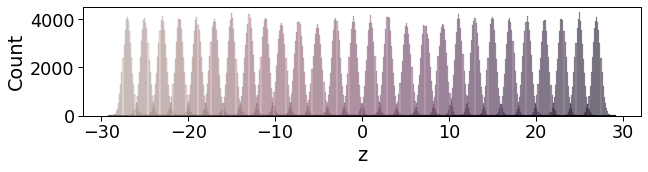

In [448]:
plt.figure(figsize=(10,2))
sns.set_context("paper", font_scale=2)
#a4_dims = (30, 10)
#fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(x='z', hue='win',data=Zdata, legend=False, binwidth=0.125)

In [160]:
corrTime=[]
for win in np.arange(0,28,1):
    corrFiles='/'.join(['/data/lyna/CNT/US-step9/'+'step8_window'+'%02g'%win+'.dat.corrtime'])
    print(corrFiles)
    tempTable=pd.read_csv(corrFiles,delim_whitespace=True,names=["time","corr","autocorr"])
    tempTable['win']=win
    corrTime.append(copy.deepcopy(tempTable))
    
corrTime=pd.concat(corrTime)
corrTime

/data/lyna/CNT/US-step9/step8_window00.dat.corrtime
/data/lyna/CNT/US-step9/step8_window01.dat.corrtime
/data/lyna/CNT/US-step9/step8_window02.dat.corrtime
/data/lyna/CNT/US-step9/step8_window03.dat.corrtime
/data/lyna/CNT/US-step9/step8_window04.dat.corrtime
/data/lyna/CNT/US-step9/step8_window05.dat.corrtime
/data/lyna/CNT/US-step9/step8_window06.dat.corrtime
/data/lyna/CNT/US-step9/step8_window07.dat.corrtime
/data/lyna/CNT/US-step9/step8_window08.dat.corrtime
/data/lyna/CNT/US-step9/step8_window09.dat.corrtime
/data/lyna/CNT/US-step9/step8_window10.dat.corrtime
/data/lyna/CNT/US-step9/step8_window11.dat.corrtime
/data/lyna/CNT/US-step9/step8_window12.dat.corrtime
/data/lyna/CNT/US-step9/step8_window13.dat.corrtime
/data/lyna/CNT/US-step9/step8_window14.dat.corrtime
/data/lyna/CNT/US-step9/step8_window15.dat.corrtime
/data/lyna/CNT/US-step9/step8_window16.dat.corrtime
/data/lyna/CNT/US-step9/step8_window17.dat.corrtime
/data/lyna/CNT/US-step9/step8_window18.dat.corrtime
/data/lyna/C

,time,corr,autocorr,win
0,0.0,1.000000,0.241574,0
1,0.5,0.554546,0.241574,0
2,1.0,0.323490,0.241574,0
3,1.5,0.199123,0.241574,0
4,2.0,0.125486,0.241574,0
...,...,...,...,...
95,47.5,0.007686,0.237808,27
96,48.0,0.010239,0.237808,27
97,48.5,0.005891,0.237808,27
98,49.0,0.006361,0.237808,27


In [508]:
corrTime

,time,corr,autocorr,win,index
0,0.0,1.000000,0.241574,0,0
1,0.5,0.554546,0.241574,0,0
2,1.0,0.323490,0.241574,0,0
3,1.5,0.199123,0.241574,0,0
4,2.0,0.125486,0.241574,0,0
...,...,...,...,...,...
95,47.5,0.007686,0.237808,27,0
96,48.0,0.010239,0.237808,27,0
97,48.5,0.005891,0.237808,27,0
98,49.0,0.006361,0.237808,27,0


In [509]:
conditions=[(corrTime.win<=8),(corrTime.win>8)&(corrTime.win<19),(corrTime.win>=19)]
choices=['out','in','out']
corrTime['index']=np.select(conditions, choices)
corrTime

,time,corr,autocorr,win,index
0,0.0,1.000000,0.241574,0,out
1,0.5,0.554546,0.241574,0,out
2,1.0,0.323490,0.241574,0,out
3,1.5,0.199123,0.241574,0,out
4,2.0,0.125486,0.241574,0,out
...,...,...,...,...,...
95,47.5,0.007686,0.237808,27,out
96,48.0,0.010239,0.237808,27,out
97,48.5,0.005891,0.237808,27,out
98,49.0,0.006361,0.237808,27,out


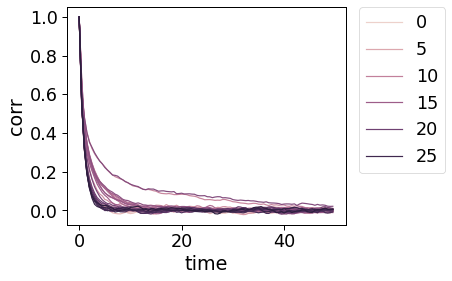

In [516]:
plt.figure(figsize=(5,4))
sns.set_context("paper", font_scale=2)
sns.lineplot(x=corrTime["time"], y=corrTime["corr"], hue=corrTime['win'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

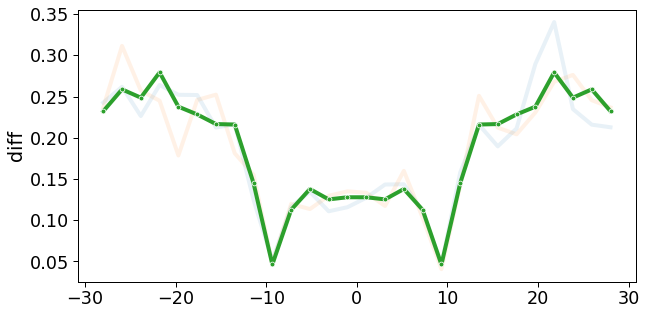

In [14]:
# tempTable=[]
# DiffTable=[]
# for group in corrTime.groupby("win"):
#     plotName,plotData=group
#     Diff=plotData["autocorr"][0]/np.trapz(y=plotData["corr"],x=plotData["time"])
#     tempTable.append(Diff)
#     DiffTable=pd.DataFrame(tempTable, columns=['diff'])
# DiffTable['win']=np.arange(0,28,1)   
#print(DiffTable)
# DiffTable.to_csv("step8_diffusionCoef.dat", index=False)

plt.figure(figsize=(10,5))
sns.set_context("paper", font_scale=2)
DiffTable2=pd.read_csv("step9_diffusionCoef.dat")
DiffTable=pd.read_csv("step8_diffusionCoef.dat")
sns.lineplot(x=np.linspace(-28,28,28), y=DiffTable['diff'], linewidth=4,alpha=0.1)
sns.lineplot(x=np.linspace(-28,28,28), y=DiffTable2['diff'], linewidth=4,alpha=0.1)

avg=[]
avg=pd.DataFrame(0.5*(DiffTable['diff']+DiffTable2['diff']))
rev=avg.loc[::-1].reset_index(drop=True)
sym=0.5*(avg+rev)

sns.lineplot(x=np.linspace(-28,28,28), y=sym['diff'],linewidth=4,marker="o")

sym.to_csv("sym_diffusionCoef.dat", index=False)

#plt.xlabel("CNT US window")
#plt.ylabel("D(AA/ps)")
#plt.grid()

    

wavelength($\AA$)


          z       pmf  pmfError
0   -27.965  0.649697  0.248896
1   -27.895  1.024074  0.251633
2   -27.825  0.823582  0.246422
3   -27.755  0.846739  0.245156
4   -27.685  0.656146  0.241928
..      ...       ...       ...
795  27.685  0.439560  0.085272
796  27.755  0.577374  0.092356
797  27.825  0.690476  0.099994
798  27.895  0.896205  0.113391
799  27.965  0.837570  0.117268

[800 rows x 3 columns]


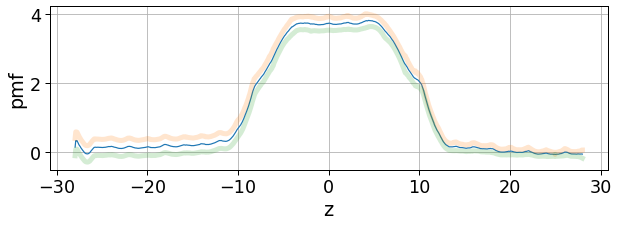

In [61]:
# US pmf computed from wham using 40ns per window and 0.5ps per frame
#!sed '/#/d' /data/yichun/nanotube_test/US/data_folder/wham_pmf.out > /data/lyna/CNT/US-pmf.dat
#pmf=pd.read_csv("/data/lyna/CNT/US-pmf.dat", delim_whitespace=True, names=["z","pmf","pmfError","prob","probError"])
pmf=pd.read_csv("mbar_data_s9.csv", delim_whitespace=True, names=['z','pmf','pmfError'])
print(pmf)
pmf['pmf']=pmf['pmf'].rolling(window=30,min_periods=1).mean()
#pmf['pmfError']=pmf['pmfError'].rolling(window=30,min_periods=1).mean()
plt.figure(figsize=(10,3))
sns.set_context("paper", font_scale=2)
sns.lineplot(x=pmf.z, y=pmf.pmf-0.5)
sns.lineplot(x=pmf.z, y=pmf.pmf-0.5+pmf.pmfError,linewidth=5,alpha=0.2)
sns.lineplot(x=pmf.z, y=pmf.pmf-0.5-pmf.pmfError,linewidth=5,alpha=0.2)
plt.grid()

In [62]:
sym=pd.read_csv('sym_diffusionCoef.dat',delim_whitespace=True)
print (sym.head())

       diff
0  0.232148
1  0.258651
2  0.248624
3  0.279256
4  0.237672


In [63]:
Dz=pd.DataFrame(sym)
Dz['Z']=np.linspace(-28,28,28)
Dz

,diff,Z
0,0.232148,-28.000000
1,0.258651,-25.925926
2,0.248624,-23.851852
3,0.279256,-21.777778
4,0.237672,-19.703704
5,0.228267,-17.629630
6,0.216591,-15.555556
7,0.216026,-13.481481
8,0.144885,-11.407407
9,0.046256,-9.333333


In [72]:
pmfinterp=np.interp(Dz['Z'],pmf['z'],pmf['pmf'])
pmfErrorinterp=np.interp(Dz['Z'],pmf['z'],pmf['pmfError'])
newpmf=pd.DataFrame(pmfinterp,columns=['pmf'])
print (newpmf.head())
#print (pmfErrorinterp)
newpmf['pmfError']=pmfErrorinterp
newpmf['Z']=Dz['Z']
print (newpmf.head())
#plt.scatter(newpmf.Z, newpmf.pmf)

        pmf
0  0.649697
1  0.625175
2  0.665683
3  0.662381
4  0.647505
        pmf  pmfError          Z
0  0.649697  0.248896 -28.000000
1  0.625175  0.244529 -25.925926
2  0.665683  0.240127 -23.851852
3  0.662381  0.236157 -21.777778
4  0.647505  0.233855 -19.703704


         pmf  pmfError          Z
23  0.521394  0.096180  19.703704
24  0.525448  0.090216  21.777778
25  0.472144  0.085229  23.851852
26  0.494252  0.094951  25.925926
27  0.447260  0.117268  28.000000


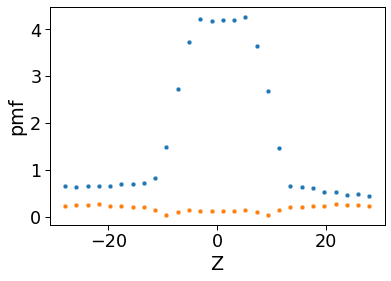

In [73]:
sns.scatterplot(x=newpmf['Z'],y=newpmf['pmf'])
sns.scatterplot(x=Dz['Z'],y=Dz['diff'])
print (newpmf.tail())

In [2]:
from scipy.constants import pi
pi
kb=0.001985875
NA=6.02*(10**23)
R=6
beta=1/(kb*300)
1/beta
print("piR^2", pi*R*R)

piR^2 113.09733552923255


In [75]:
# Permeability computed from the inhomogeneous solubility-diffusion equation

#Pdiffu=pi*R*R/(np.trapz(y=(np.exp(beta*newpmf['pmf']))/Dz['diff'], x=Dz['Z']))  # cubic A/ps
Pdiffu=pi*R*R/(np.trapz(y=(np.exp(beta*newpmf['pmf']))/Dz['diff'], x=Dz['Z']))
print('permeability in A^3/ns:', Pdiffu*1000,'permeability in cm^3/s:', Pdiffu*10**(-12))
print('resistance is 1/P:', 1/Pdiffu)


permeability in A^3/ns: 0.9506178702292394 permeability in cm^3/s: 9.506178702292395e-16
resistance is 1/P: 1051.9474031756338


In [49]:
# test=pd.read_csv('0.5ps_final.pmf.csv',delim_whitespace=True)
# test.columns=['z','pmf']

# wham_5ps=pd.read_csv('mbar_data_s9.csv',delim_whitespace=True, header=None)
# wham_5ps={'z_coor':wham_5ps[0],'pmf':wham_5ps[1],'sd':wham_5ps[2]}
# wham_5ps=pd.DataFrame(wham_5ps)
# print (wham_5ps)
# wham_5ps['pmf']=wham_5ps['pmf'].rolling(window=30, min_periods=1).mean()


# plt.scatter(test.z, test.pmf-1.8,label='milestone')
# plt.scatter(wham_5ps['z_coor'], wham_5ps['pmf']-0.5, label='mbar last 20ns')
# test['newpmf']=test.pmf-1.8
# print (test.head())
# plt.legend()

In [71]:
# Permeability computed from mfpt

mfpt=2.6*10**6 # ps
Pmfpt=pi*R*R*np.trapz(y=np.exp(-beta*newpmf['pmf']-0.5), x=newpmf['Z'])/(2*mfpt)
print('permeability in A^3/ns:', Pmfpt*1000,'permeability in cm^3/s:', Pmfpt*10**(-12))

permeability in A^3/ns: 0.37183002960457423 permeability in cm^3/s: 3.718300296045742e-16


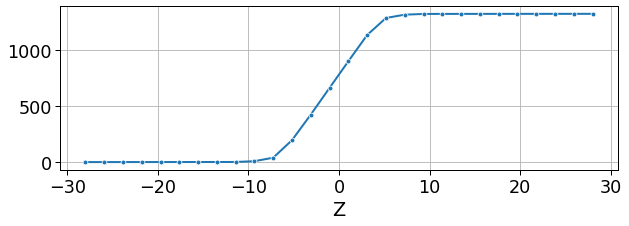

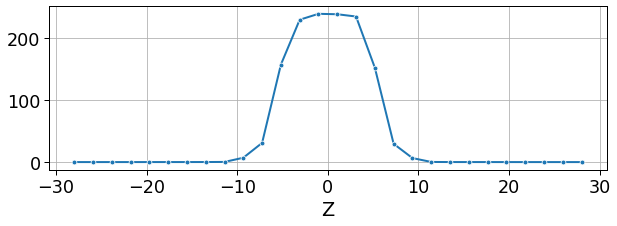

In [580]:
# just do some checking, no need to run this cell
expP=(np.exp(beta*newpmf['pmf']))/(pi*R*R)
expN=pi*R*R*np.exp(-beta*newpmf['pmf'])
xgrid=2

plt.figure(figsize=(10,3))
sns.set_context("paper", font_scale=2)
sns.lineplot(x=newpmf['Z'], y=np.cumsum((expP/Dz['diff'])*xgrid), marker='o', linewidth=2)
np.max(np.cumsum((expP/Dz['diff'])*xgrid))
plt.grid()
plt.show()

plt.figure(figsize=(10,3))
sns.set_context("paper", font_scale=2)
sns.lineplot(x=newpmf['Z'], y=(expP/Dz['diff'])*xgrid, marker='o',linewidth=2 )
plt.grid()
#sns.scatterplot(x=newpmf['Z'], y=(expP))
#sns.scatterplot(x=newpmf['Z'], y=np.cumsum((expN))/mfpt)
#sns.scatterplot(x=newpmf['Z'], y=np.cumsum((xgrid*expN)/(2*mfpt)), color='g')


In [3]:
# Permeability computed from voltage 
# https://psychology.wikia.org/wiki/GHK_current_equation
# The charge that each electron carries is 1.60 x 10-19 coulombs
# 1 mole of electrons is NA electrons
# 1 coulomb is the negative charge of 6.24*10^18 e
# Faraday constant is the charge of one mole electron, thus unit Coulomb/mol, or J/V/mol, since J/V=Coulomb

coulomb=6.24*10**18 
NA=6.02*(10**23)
F=NA/coulomb
print(F)

RT=8.314*300.15 # J/mol
kT=26.7 # emV

# carbone nanotube K+ concentration under voltage and cylinder volume
numberIon=1
R=6
#Length=(74-18)/2
Length=(28-9) #for milestone and umbrella sampling bulk concentration
volum=pi*R*R*Length
conc=(10**27)*((numberIon/NA)/volum)
print("concentration", conc, "M")

c=conc*1000 # concentration in mol/m^3
gamma=1 # K+ conductance in pS, one coulomb/ps/V

P=gamma*10**(-12)/(c*F*F/RT) # K+ permeability in m^3/s
print("permeability in A^3/ns", P*10**21, "permeability in cm^3/s", P*10**6)

# We can get the same answer using P=gamma*kT/conc
print((gamma*10**(-12))*kT/(conc*F))

96474.35897435897
concentration 0.7730321107608913 M
permeability in A^3/ns 0.34683828521444704 permeability in cm^3/s 3.46838285214447e-16
3.5801549667923314e-16


In [335]:
# Use P = gamma*kT/conc to check permeability in cm^3/s from Table 1 of JCIM2019 using eq 4

# P=1.2(C/pS/V) *25.7 (mV) / 0.13(mol/L)
# P=1.2*10**12 (C/S/V) * 25.7*10**(-3) (V) / 0.13*96320*10**(-3) (C/cm^3)
print( "permeability in cm^3/s from Table 1 ",
      (1.2*10**(-12)) * (25.7*10**(-3)) / (0.13*F*10**(-3)))


permeability in cm^3/s from Table 1  2.459003322259136e-15


In [353]:
# Testing eq.3 gamma=k0/kT (note both gamma and k0=1/mfpt depend on conc, thus conc cancels out)
print("conductance in Table1 in pS is:",10**12*(2*10**5)/0.0257/coulomb)


conductance in Table1 in pS is: 1.2471315973261496


In [359]:
# assume mfpt is linear with conc which is 6 times in voltage simualtion

k0=10**12*(6/mfpt) 
print(mfpt, "ps", k0, "per second")
print(10**12*k0/0.0257/coulomb, "conductance from mfpt in pS")

2600000.0 ps 2307692.3076923075 per second
14.38997996914788 conductance from mfpt in pS
